# Animal Shelter

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


# 1. Data Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [5]:
df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
df[["SexuponOutcome", "Sex", "Neutered"]].head()

,SexuponOutcome,Sex,Neutered
0,Neutered Male,male,True
1,Spayed Female,female,True
2,Neutered Male,male,True
3,Intact Male,male,False
4,Neutered Male,male,True


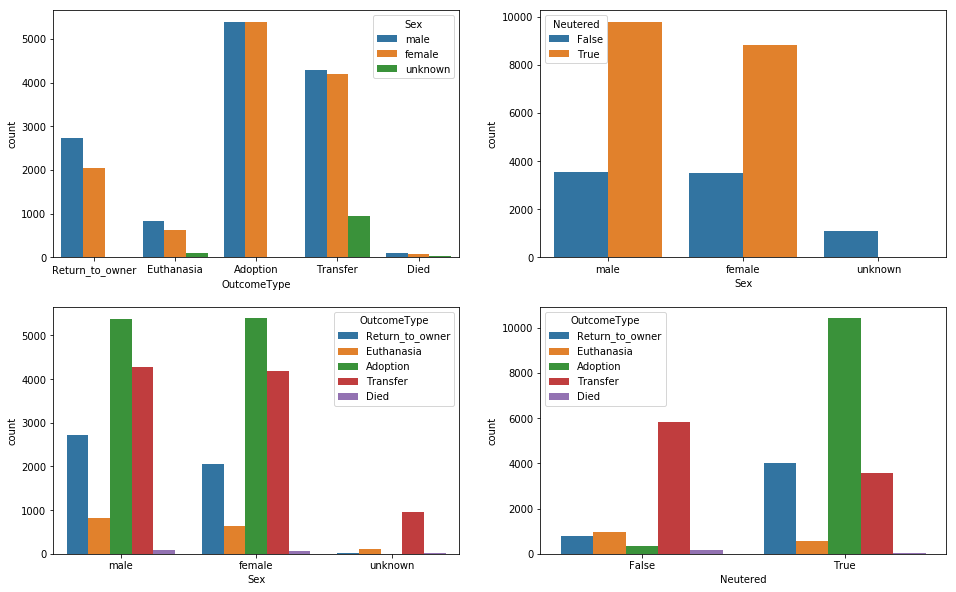

In [6]:
f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=df, x='Sex',hue='OutcomeType', ax=ax2)
sns.countplot(data=df, x="Sex", hue="Neutered", ax=ax3)
sns.countplot(data=df, x="Neutered", hue="OutcomeType", ax=ax4)

Clean up breed

In [7]:
df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
df[["Breed", "PureBreed"]].head(10)

,Breed,PureBreed
0,Shetland Sheepdog Mix,False
1,Domestic Shorthair Mix,False
2,Pit Bull Mix,False
3,Domestic Shorthair Mix,False
4,Lhasa Apso/Miniature Poodle,False
5,Cairn Terrier/Chihuahua Shorthair,False
6,Domestic Shorthair Mix,False
7,Domestic Shorthair Mix,False
8,American Pit Bull Terrier Mix,False
9,Cairn Terrier,True


Plot normalized ratios of outcomes by breed purity. Purebreed dogs are more likely to be returned to owner (not surprising), however not more likely to be adopted(surprising).

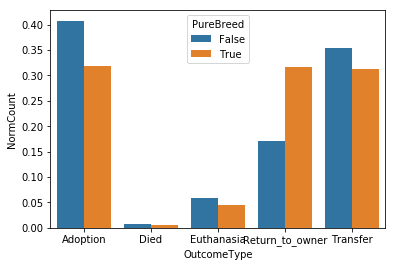

In [8]:
def normalizeCounts(df, x, sub_x, local_agg=False):

    agg1 = df.pivot_table(index=[x, sub_x], values=["AnimalID"], aggfunc=len)

    agg1.columns=["NormCount"]
    agg1["NormCount"] = agg1["NormCount"].astype(float)
    agg2 = df.pivot_table(index=[sub_x], values="AnimalID", aggfunc=len)
    #print agg2
    
    x_vals = agg1.index.levels[0].values
    
    #print agg1
    for x_val in x_vals:
        sub_x_vals = agg1.loc[x_val].index.unique().values
        if local_agg:
            tot = sum(agg1.loc[x_val, "NormCount"].values)
        
            
        for sub_x_val in sub_x_vals:
            if not local_agg:
                tot = agg2.loc[sub_x_val][0]
        
            val = agg1.loc[x_val].loc[sub_x_val,"NormCount"]
            val /= tot
            agg1.loc[x_val].loc[sub_x_val]=val


    agg1 = agg1.reset_index()
    #print agg1
    
    return agg1

sns.barplot(data=normalizeCounts(df, "OutcomeType", "PureBreed"), x="OutcomeType", hue="PureBreed", y="NormCount")
#sns.countplot(data=df, x="OutcomeType", hue="PureBreed")

Dog breed dataset collated from http://www.dogsindepth.com/dog_breed_size_chart.html.

Dogs breeds are classified according to size from 1 (smallest) to 8 (largest)

In [9]:
breedsdf = pd.read_csv("breeds.csv")
breedsdf.head(20)

,Breed,Size
0,chihuahua,1
1,Affenpinscher,2
2,Cairn Terrier,2
3,German Spitz,2
4,Spitz,2
5,Kleinspitz,2
6,Havanese,2
7,Japanese Chin,2
8,Maltese,2
9,Norfolk Terrier,2


Train a NB classifier in an attempt to estimate dog size by breed. 

In the case of mixes, the Naive Bayes classifier should give us an probable estimate based on the constituent breeds.

This will never be exact, but it should give us a useful indication.

N.B. We do not calculate accuracy for this classifier because there is no repeated information in the data set, so it does not make sense to split it into training and test sets. The Naive Bayes classifier here should be simply understood as a convenient way of matching breed names and combining breeds in the case of a mix. Visual inspection indicates that the results are quite satisfactory.

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

vec = CountVectorizer()
knownBreedsTDM = vec.fit_transform(breedsdf.loc[:,"Breed"])

#pca = PCA()
#reduced_dims = pca.fit_transform(knownBreedsTDM.toarray())



breedsClf = GaussianNB()
breedsClf.fit(knownBreedsTDM.toarray(), breedsdf.loc[:, "Size"])

GaussianNB(priors=None)

Generate size estimates for our animals...cats are very uniformly sized and we set them to size 1.

In [11]:
unknownBreedsTDM = vec.transform(df.loc[:,"Breed"])
#reduced_dims = pca.transform(unknownBreedsTDM.toarray())
#print unknownBreedsTDM.toarray()[0]==True

#for i in range(0,20):
#    print df.iloc[i][["AnimalType", "Breed"]].values ,np.array(vec.get_feature_names())[unknownBreedsTDM.toarray()[i]==True]
    
sizes = breedsClf.predict(unknownBreedsTDM.toarray())

df["Size"] = sizes

df.loc[df["AnimalType"]=="Cat", "Size"] = 1
df[["AnimalType", "Breed", "PureBreed", "Size"]].head(20)
#df[["AnimalType", "Breed", "PureBreed", "Size"]].sort_values(by=["Size"], axis=0, ascending=True)


,AnimalType,Breed,PureBreed,Size
0,Dog,Shetland Sheepdog Mix,False,4
1,Cat,Domestic Shorthair Mix,False,1
2,Dog,Pit Bull Mix,False,5
3,Cat,Domestic Shorthair Mix,False,1
4,Dog,Lhasa Apso/Miniature Poodle,False,3
5,Dog,Cairn Terrier/Chihuahua Shorthair,False,2
6,Cat,Domestic Shorthair Mix,False,1
7,Cat,Domestic Shorthair Mix,False,1
8,Dog,American Pit Bull Terrier Mix,False,5
9,Dog,Cairn Terrier,True,2


Plot a size distribution of dogs. We seem to have a majority of medium sized dogs and very few very big ones. This is as expected for a standard animal shelter. 

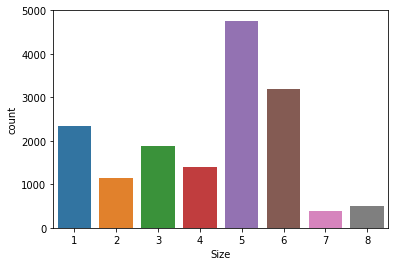

In [12]:
sns.countplot(data=df.loc[df["AnimalType"]=="Dog"], x="Size")

Explore outcomes by size. Interesting that the very large dogs seem to have smaller odds of being adopted. Small dogs are, however the most likely to be adopted. This is also not surprising. Also medium/large dogs (size 5) are by far the most likely to be euthanized.

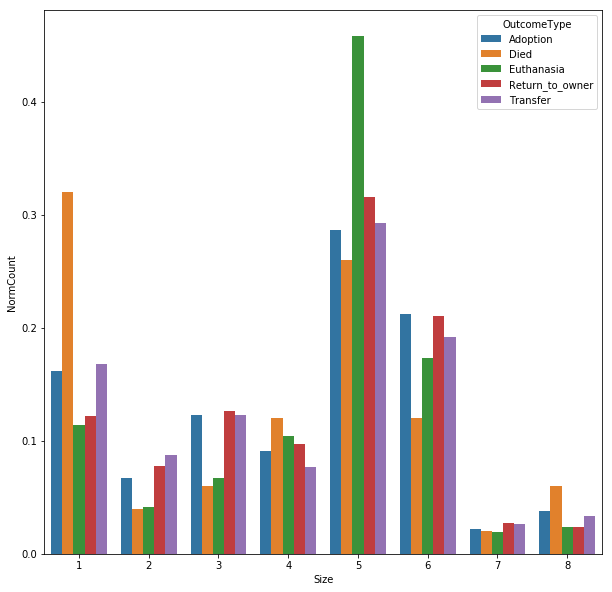

In [13]:
# Generate distribution of dog sizes grouped by outcome, normalized over outcome.
f, ax1 = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(data=normalizeCounts(df.loc[df["AnimalType"]=="Dog"], "Size", "OutcomeType"), x="Size", hue="OutcomeType", y="NormCount")



Plot of the same data, but unnormalized. 

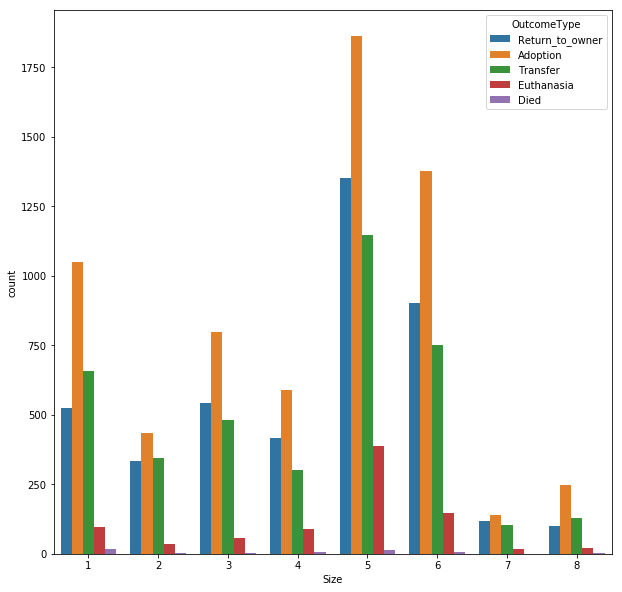

In [14]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 10))
sns.countplot(data=df.loc[df["AnimalType"]=="Dog"], x="Size", hue="OutcomeType")

We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, ADULT, SENIOR). 

In [15]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
meanAge = df[["AgeDays"]].mean()

df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]


A quick histogram of age distribution shows that most animals at the shelter are younger than about 2 years of age.

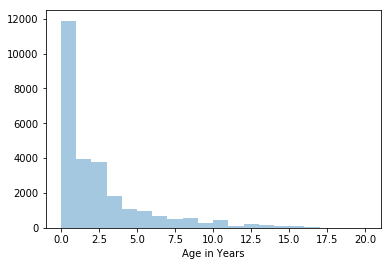

In [16]:

sns.distplot(df.AgeDays/365, bins = 20, kde=False, axlabel="Age in Years")

Visualising outcomes based on these age categories reveals, unsurprisingly, that babies are more likely to be adopted (or transferred) than any other age bracket. Sadly the data also reveals that babies are the most likely to die at the shelter.

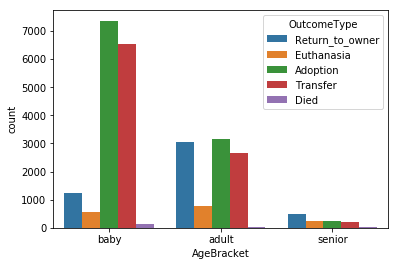

In [17]:
def getAgeBracket(ageInDays):
    if ageInDays<=365:
        return "baby"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"
    
df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)

sns.countplot(data=df, x="AgeBracket", hue="OutcomeType")

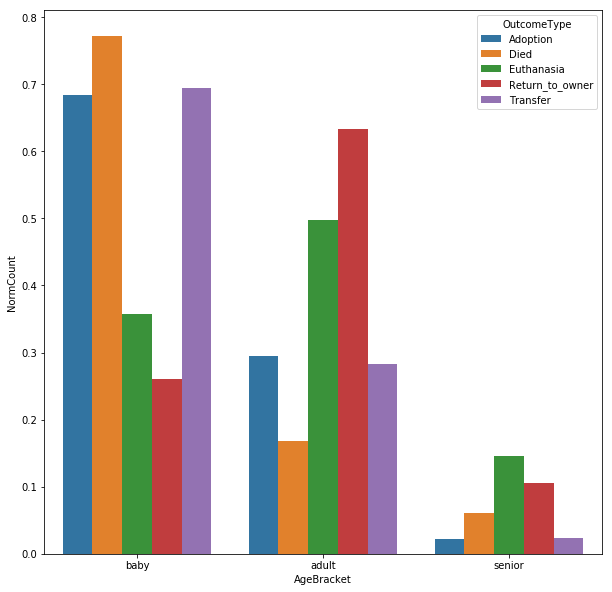

In [18]:
# Generate distribution of dog sizes grouped by outcome, normalized over outcome.
f, ax1 = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(data=normalizeCounts(df, "AgeBracket", "OutcomeType"), x="AgeBracket", hue="OutcomeType", y="NormCount", order=["baby", "adult", "senior"])



Here we also take the DateTime column and we categorize split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 15:00.

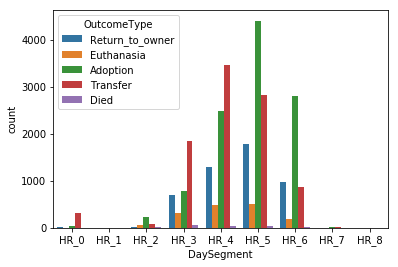

In [19]:
df["DateTime"] = pd.to_datetime(df["DateTime"])

def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)

sns.countplot(data=df, x="DaySegment", hue="OutcomeType", order=["HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8"])

Does the day of the week make a difference to the outcomes? 

It looks like adoptions are much more likely during the weekend.

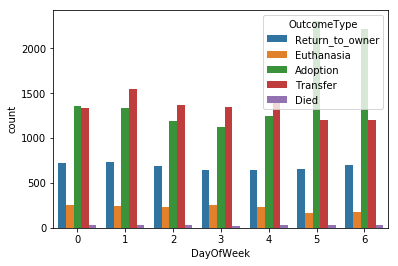

In [20]:
weekdist = pd.DataFrame(data=df[["DateTime", "OutcomeType"]])
weekdist["DayOfWeek"] = weekdist["DateTime"].apply(lambda ts: ts.weekday())

sns.countplot(data=weekdist, x="DayOfWeek", hue="OutcomeType")

In order to capture this information we create a new "IsWeekend" field in our dataset.

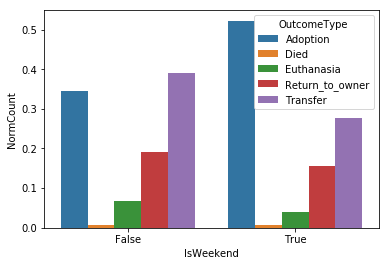

In [21]:
df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))

#sns.countplot(data=df, x="IsWeekend", hue="OutcomeType")

sns.barplot(data=normalizeCounts(df, "IsWeekend", "OutcomeType", local_agg=True), x="IsWeekend", hue="OutcomeType", y="NormCount")

Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

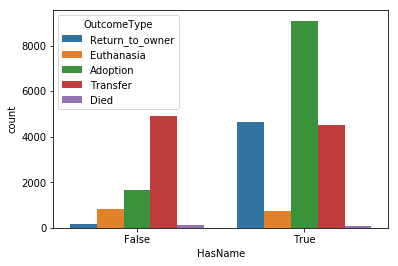

In [22]:
df["HasName"] = ~df["Name"].isnull()

sns.countplot(data=df, x="HasName", hue="OutcomeType")

We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [23]:
df["Color"].unique().size

366

In [24]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/")[0].split(" ")[0])

print df["SimpleColor"].unique().size
df[["Color", "SimpleColor"]].head()


29


,Color,SimpleColor
0,Brown/White,Brown
1,Cream Tabby,Cream
2,Blue/White,Blue
3,Blue Cream,Blue
4,Tan,Tan


# Machine Learning Model

Prepare a dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for out learning algorithm not to be trivial, we will remove this field.

In [25]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Sex,Neutered,PureBreed,Size,AgeDays,AgeBracket,DaySegment,IsWeekend,HasName,SimpleColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,male,True,False,4,365.0,baby,HR_6,False,True,Brown
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,female,True,False,1,365.0,baby,HR_4,True,True,Cream
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,male,True,False,5,730.0,adult,HR_4,True,True,Blue
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,male,False,False,1,21.0,baby,HR_6,False,False,Blue
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,male,True,False,3,730.0,adult,HR_4,False,False,Tan


Select only the fields we need for learning.

In [26]:
prepared_df = pd.DataFrame(df[["OutcomeType", "AnimalType", "SimpleColor", "Sex", "Neutered", "PureBreed", "Size", "AgeBracket", "DaySegment", "IsWeekend", "HasName"]])

prepared_df.head()

,OutcomeType,AnimalType,SimpleColor,Sex,Neutered,PureBreed,Size,AgeBracket,DaySegment,IsWeekend,HasName
0,Return_to_owner,Dog,Brown,male,True,False,4,baby,HR_6,False,True
1,Euthanasia,Cat,Cream,female,True,False,1,baby,HR_4,True,True
2,Adoption,Dog,Blue,male,True,False,5,adult,HR_4,True,True
3,Transfer,Cat,Blue,male,False,False,1,baby,HR_6,False,False
4,Transfer,Dog,Tan,male,True,False,3,adult,HR_4,False,False


Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [68]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
     ('OutcomeType', preprocessing.LabelEncoder()),
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     ("Size", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", preprocessing.LabelBinarizer())
], df_out=True)


prepared_fitted_df = mapper.fit_transform(prepared_df)
print prepared_fitted_df.columns
# Drop redundant columns to avoid the Dummy Variable Trap
prepared_fitted_df.drop(["Sex_unknown", "Size_8", "SimpleColor_Ruddy", "AgeBracket_senior", "DaySegment_HR_7" ], axis=1)
prepared_fitted_df.to_csv("prepared_data.csv", index=False)

prepared_fitted_df



Index([u'OutcomeType', u'AnimalType', u'Sex_female', u'Sex_male',
       u'Sex_unknown', u'Neutered', u'PureBreed', u'Size_1', u'Size_2',
       u'Size_3', u'Size_4', u'Size_5', u'Size_6', u'Size_7', u'Size_8',
       u'AgeBracket_adult', u'AgeBracket_baby', u'AgeBracket_senior',
       u'DaySegment_HR_0', u'DaySegment_HR_1', u'DaySegment_HR_2',
       u'DaySegment_HR_3', u'DaySegment_HR_4', u'DaySegment_HR_5',
       u'DaySegment_HR_6', u'DaySegment_HR_7', u'IsWeekend', u'HasName',
       u'SimpleColor_Agouti', u'SimpleColor_Apricot', u'SimpleColor_Black',
       u'SimpleColor_Blue', u'SimpleColor_Brown', u'SimpleColor_Buff',
       u'SimpleColor_Calico', u'SimpleColor_Chocolate', u'SimpleColor_Cream',
       u'SimpleColor_Fawn', u'SimpleColor_Flame', u'SimpleColor_Gold',
       u'SimpleColor_Gray', u'SimpleColor_Lilac', u'SimpleColor_Liver',
       u'SimpleColor_Lynx', u'SimpleColor_Orange', u'SimpleColor_Pink',
       u'SimpleColor_Red', u'SimpleColor_Ruddy', u'SimpleColor_Sable',
 

,OutcomeType,AnimalType,Sex_female,Sex_male,Sex_unknown,Neutered,PureBreed,Size_1,Size_2,Size_3,...,SimpleColor_Ruddy,SimpleColor_Sable,SimpleColor_Seal,SimpleColor_Silver,SimpleColor_Tan,SimpleColor_Torbie,SimpleColor_Tortie,SimpleColor_Tricolor,SimpleColor_White,SimpleColor_Yellow
0,3,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,4,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Split the prepared dataset into features and classes arrays so that we can pass them to sklearn classifiers.

In [60]:
features_array = prepared_fitted_df.iloc[:,1:].values
classes_array = prepared_fitted_df[["OutcomeType"]].values

In [61]:
from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(features_array, classes_array, test_size=0.4, random_state=0)

In [62]:
y_train

array([[0],
       [2],
       [4],
       ..., 
       [4],
       [0],
       [4]])

In [97]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

clf = MultinomialNB()
selector = RFECV(svm.SVC(kernel="linear"), cv=3)
selector.fit(X_train, y_train)
print selector.support_
print selector.grid_scores_


[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True False  True  True False  True False False False
  True  True False False False  True  True  True False  True  True False
 False False False  True  True  True False  True False  True False  True]


In [99]:
print selector.grid_scores_

[ 0.60828047  0.61021374  0.61283203  0.61457821  0.61464057  0.61607346
  0.61838005  0.61831774  0.622309    0.62299475  0.62586359  0.62692368
  0.62704836  0.62979245  0.62835799  0.63054069  0.63116428  0.63197513
  0.63478149  0.63951942  0.63889578  0.64245071  0.64126553  0.64101624
  0.64170228  0.64276337  0.64475817  0.64756434  0.64637974  0.6483128
  0.64625475  0.64743982  0.6465668   0.6458806   0.64712796  0.64824997
  0.64731491  0.6451323   0.64581818  0.64669125  0.64825046  0.64750198
  0.64725245  0.64575619  0.64563102  0.64563102  0.64563102  0.64563102]


In [98]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

X_train_fitted = X_train[:,selector.support_]
clf = OneVsRestClassifier(svm.SVC(kernel="linear"), n_jobs=4)

scores = cross_val_score(clf, X_train_fitted, np.ravel(y_train), cv=2)
print scores
print np.average(scores)


[ 0.60473815  0.62317575]
0.613956953071


In [80]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm


#clf = RandomForestClassifier(n_estimators=10)
#clf = LogisticRegression(penalty="l1", C=10)
#svm.SVC(kernel='rbf', C=1)
clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=50), algorithm="SAMME").fit(X_train, y_train)



In [81]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, np.ravel(y_train), cv=2)
print scores
print np.average(scores)

[ 0.61783042  0.62779094]
0.622810684092
